In [1]:
#%matplotlib inline
import time
import cv2

import numpy as np
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from IPython import display


Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

In [3]:
video_path = 'Pictures/traffic.avi'
video_capture = cv2.VideoCapture(video_path)

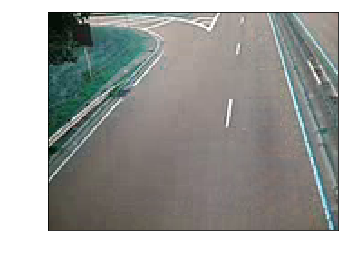

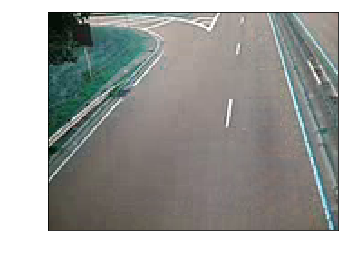

In [4]:
while video_capture.isOpened():
    _, frame = video_capture.read()
    if not frame is None:
        plt.imshow(frame)
        plt.draw()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.01)
    else:
        plt.draw()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.01)
        break

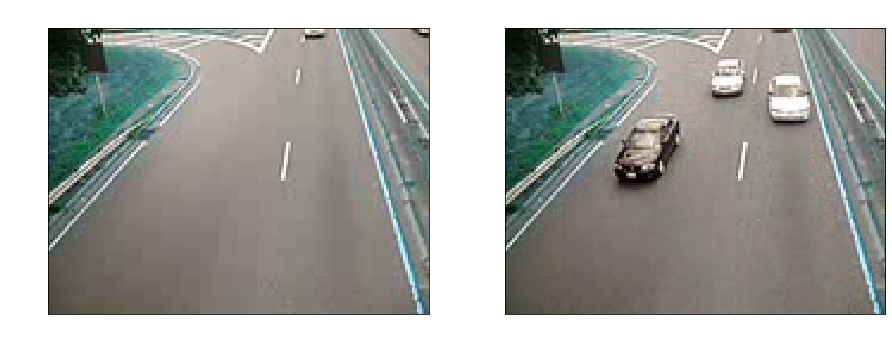

In [7]:
width  = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
length = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

video_capture.set(cv2.CAP_PROP_POS_FRAMES,0)
_, background_image = video_capture.read()

video_capture.set(cv2.CAP_PROP_POS_FRAMES, 67)
_, image_with_cars = video_capture.read()

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(background_image)
plt.title("background_image")
plt.subplot(122)
plt.title("Image wit cars")
plt.imshow(image_with_cars)

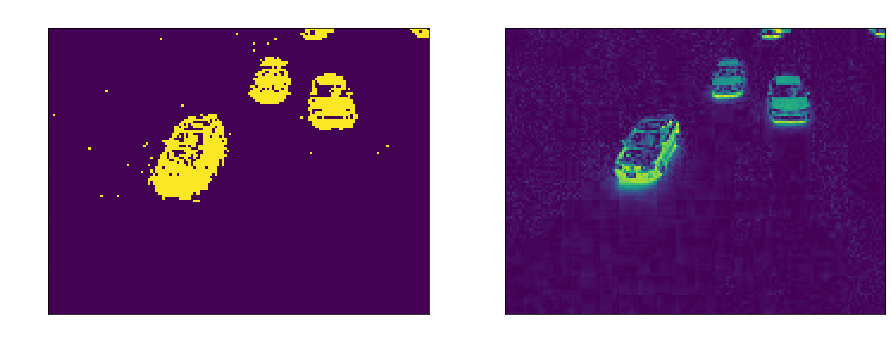

In [8]:
from skimage.measure import label, regionprops, regionprops_table
from skimage import morphology

diff_image = np.abs(rgb2gray(background_image) - rgb2gray(image_with_cars))

diff_thresholded = diff_image*255 > 20

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(diff_thresholded)
plt.title("background_image")
plt.subplot(122)
plt.title("Image wit cars")
plt.imshow(diff_image)

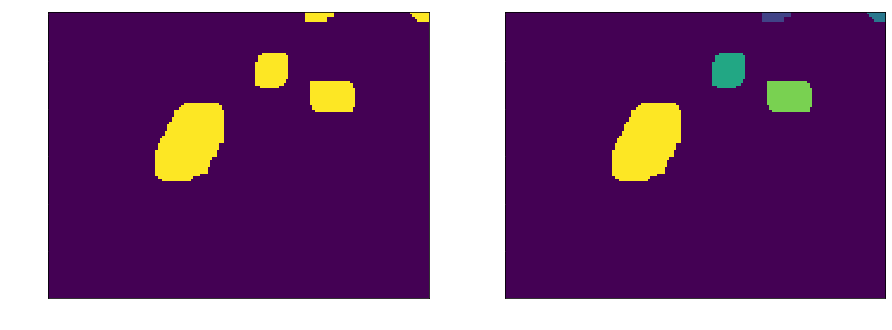

In [9]:
diff_thresholded = morphology.opening(
    morphology.remove_small_holes(diff_thresholded,area_threshold=64),
    selem=morphology.selem.rectangle(8,8))
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(diff_thresholded)

label_img = label(diff_thresholded)
regions = regionprops(label_img)
plt.subplot(122)
plt.imshow(label_img)

<Figure size 1080x720 with 0 Axes>

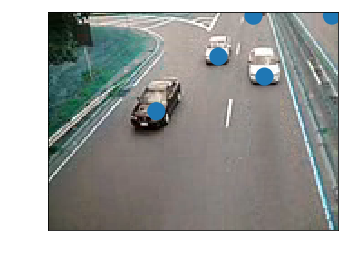

In [10]:
import matplotlib.patches as patches
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(1)
ax.imshow(image_with_cars)

for region in regions:
    centroid_viz =patches.Circle((region.centroid[1], region.centroid[0]))
    ax.add_patch(centroid_viz)

In [11]:
from skimage.draw import circle
video_capture = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./Pictures/tagged_cars.avi',fourcc, fps, (height,width))

while(video_capture.isOpened()):
    ret, frame = video_capture.read()
    if ret==True:
        #1 Detekcia objektov
        diff_image = np.abs(rgb2gray(background_image) - rgb2gray(frame))
        #2 Prahovanie objektov
        diff_thresholded = diff_image*255 > 20
        #3 Morfologicke operacie
        diff_thresholded = morphology.opening(
        morphology.remove_small_holes(diff_thresholded,area_threshold=64),
        selem=morphology.selem.rectangle(8,8))

        label_img = label(diff_thresholded)
        regions = regionprops(label_img)
        #4 Uprava vystupu na zaklade
        for region in regions:
            rr, cc = circle(region.centroid[0], region.centroid[1], 1)
            frame[rr, cc,:2] = 255
            frame[rr, cc, 2] = 0


        out.write(frame)
    else:
        break

video_capture.release()
out.release()
# DU 74-77

In [35]:
video_capture = cv2.VideoCapture(video_path)

colors = ((0,0,255),(0,255,0),(255,0,0),(255,0,255),(255,255,0),(0,255,255))

out = cv2.VideoWriter('./Pictures/tagged_cars_trajectories.avi',fourcc, fps, (height,width))

centr_disc = {
    "0":[()],
    "1":[()],
    "2":[()],
    "3":[()],
    "4":[()],
    "5":[()],
}
car_count = 0

while(video_capture.isOpened()):
    ret, frame = video_capture.read()
    key_list = []
    
    if ret==True:
        #1 Detekcia objektov
        diff_image = np.abs(rgb2gray(background_image) - rgb2gray(frame))
        #2 Prahovanie objektov
        diff_thresholded = diff_image*255 > 20
        #3 Morfologicke operacie
        diff_thresholded = morphology.opening(
        morphology.remove_small_holes(diff_thresholded,area_threshold=64),
        selem=morphology.selem.rectangle(8,8))

        label_img = label(diff_thresholded)
        regions = regionprops(label_img)
        #4 Uprava vystupu na zaklade

        for region in regions:
            rr, cc = region.centroid[0], region.centroid[1]
            distance = None
            picked_key = None

            for key in centr_disc:
                if len (centr_disc[key][-1]) > 1:
                    distance = ((centr_disc[key][-1][0] - rr)**2 + (centr_disc[key][-1][1] - cc)**2)**(1/2)
                    if distance < 20:
                        centr_disc[key].append((rr,cc))
                        if key in key_list:
                            continue
                        picked_key = key
                        break;
            
            if picked_key is None:
                for key in centr_disc:
                    if len(centr_disc[key][0]) == 0:
                        centr_disc[key] = [(rr,cc),]
                        picked_key = key
                        break;
            
            for x,y in centr_disc[key]:
                rr_x,cc_y = circle(x, y, 1)
                frame[rr_x, cc_y,:] = colors[int(key)]
                
            if picked_key is not None:
                key_list.append(key)

        for key in centr_disc:
            if key not in key_list:
                if len(centr_disc[key]) > 1:
                    car_count += 1
                centr_disc[key] = [()]
                

        
        out.write(frame)
    else:
        break

video_capture.release()
out.release()


Text(0.5, 1.0, 'image_with_cars')

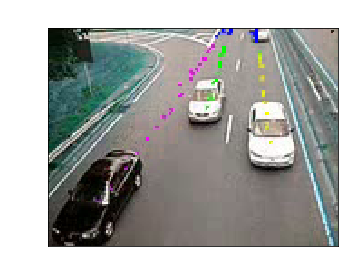

In [36]:
video_capture = cv2.VideoCapture("Pictures/tagged_cars_trajectories.avi")

video_capture.set(cv2.CAP_PROP_POS_FRAMES, 72)
_, image_with_cars = video_capture.read()

plt.imshow(image_with_cars)
plt.title("image_with_cars")


In [39]:
print('Car count =',car_count)

Car count = 28
